In [1]:
# Parameters (overridden during execution)
EPOCHS = 25
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [2]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [3]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [6]:
# -------------------------
# Config (dynamic params)
# -------------------------
BATCH_SIZE = 6
IMG_SIZE   = 224

# -------------------------
# Load data
# -------------------------
# data = np.load("/kaggle/input/pneumoniamnist.npz")
data = np.load("/content/pneumoniamnist.npz")

X_train, y_train = data["train_images"], data["train_labels"]
X_val,   y_val   = data["val_images"],   data["val_labels"]
X_test,  y_test  = data["test_images"],  data["test_labels"]

# -------------------------
# Label normalization
# -------------------------
def normalize_labels(labels: np.ndarray) -> np.ndarray:
    labels = np.asarray(labels)

    if labels.ndim == 2:
        if labels.shape[1] == 1:
            labels = labels.squeeze(axis=1)
        else:
            labels = labels.argmax(axis=1)

    return labels.astype(int)

y_train = normalize_labels(y_train)
y_val   = normalize_labels(y_val)
y_test  = normalize_labels(y_test)

print("Train images shape:", X_train.shape)
print("Val images shape:  ", X_val.shape)
print("Test images shape: ", X_test.shape)

Train images shape: (3882, 28, 28)
Val images shape:   (524, 28, 28)
Test images shape:  (624, 28, 28)


In [ ]:
from torch.utils.data import Dataset, DataLoader

# -------------------------
# PyTorch Dataset
# -------------------------
class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, img_size):
        self.img_size = img_size

        # Convert once
        self.images = torch.from_numpy(images).float()
        self.labels = torch.from_numpy(labels).long()

        # Ensure channel dimension
        if self.images.ndim == 3:
            self.images = self.images.unsqueeze(1)  # (N, 1, H, W)

        # Convert grayscale -> RGB
        if self.images.shape[1] == 1:
            self.images = self.images.repeat(1, 3, 1, 1)  # (N, 3, H, W)

        # Resize once
        if self.images.shape[2] != img_size or self.images.shape[3] != img_size:
            self.images = F.interpolate(
                self.images,
                size=(img_size, img_size),
                mode="bilinear",
                align_corners=False
            )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = PneumoniaDataset(X_train, y_train, IMG_SIZE)
val_dataset   = PneumoniaDataset(X_val,   y_val,   IMG_SIZE)
test_dataset  = PneumoniaDataset(X_test,  y_test,  IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

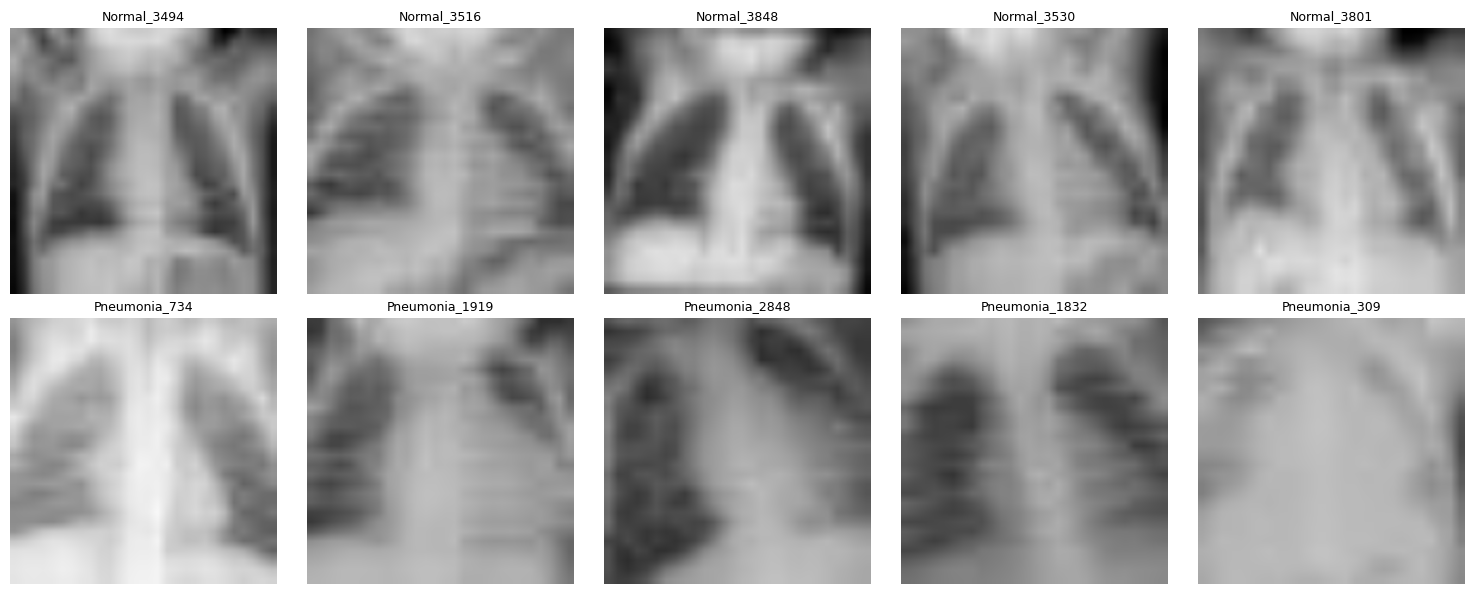

In [8]:
def show_random_images_per_class(
    dataset,
    class_names,
    n_per_class=5,
    seed=42,
    image_names=None
):
    """
    Displays n random images per class in an m x n grid.
    If image_names is None, uses ClassName_index.
    """

    random.seed(seed)
    torch.manual_seed(seed)

    labels = dataset.labels.cpu().numpy()
    images = dataset.images.cpu()
    num_classes = len(class_names)

    class_indices = [
        np.where(labels == c)[0]
        for c in range(num_classes)
    ]

    fig, axes = plt.subplots(
        num_classes,
        n_per_class,
        figsize=(3 * n_per_class, 3 * num_classes),
        squeeze=False
    )

    for cls in range(num_classes):
        idxs = class_indices[cls]
        k = min(n_per_class, len(idxs))
        selected = np.random.choice(idxs, size=k, replace=False)

        for col, idx in enumerate(selected):
            img = images[idx].permute(1, 2, 0).numpy()
            img = img / 255.0  # correct float range for imshow

            ax = axes[cls, col]
            ax.imshow(img)
            ax.axis("off")

            # Image title
            if image_names is not None:
                title = image_names[idx]
            else:
                title = f"{class_names[cls]}_{idx}"

            ax.set_title(title, fontsize=9)

            if col == 0:
                ax.set_ylabel(
                    class_names[cls],
                    rotation=90,
                    fontsize=12,
                    labelpad=10
                )

    plt.tight_layout()
    plt.show()

class_names = ["Normal", "Pneumonia"]

show_random_images_per_class(
    train_dataset,
    class_names=class_names,
    n_per_class=5
)

In [9]:
class TwoMaxMinusMinPool2d(nn.Module):
    """
    Pooling layer that computes:
        output = (2 * max_pool) - min_pool

    Uses only optimized max-pooling kernels.
    Computational cost ~ 2× max pooling.
    Output shape matches standard pooling.
    """

    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()

        # Match PyTorch pooling semantics
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        # Fast max pooling (optimized C++/CUDA)
        max_pool = F.max_pool2d(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Fast min pooling via negation trick
        min_pool = -F.max_pool2d(
            -x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Final contrast-enhanced response
        return (2.0 * max_pool) - min_pool

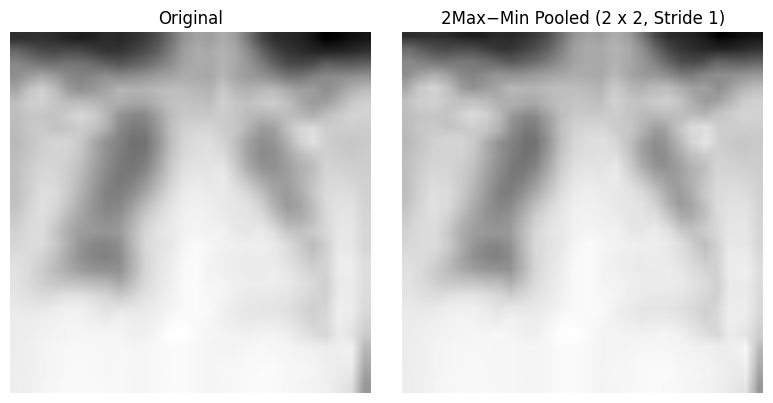

In [10]:
KERNEL_SIZE = 2
STRIDE = 1

# Get one batch
images, labels = next(iter(train_loader))

# Take first image only
img = images[0:1]  # shape: (1, C, H, W)

pool = TwoMaxMinusMinPool2d(kernel_size=KERNEL_SIZE, stride=STRIDE)
pool.eval()

with torch.no_grad():
    pooled = pool(img)

# Convert to numpy for display
img_np = img[0].cpu().numpy()
pooled_np = pooled[0].cpu().numpy()

# Pick one channel to visualize
ch = 0

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img_np[ch], cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(pooled_np[ch], cmap="gray")
axs[1].set_title(F"2Max−Min Pooled ({KERNEL_SIZE} x {KERNEL_SIZE}, Stride {STRIDE})")
axs[1].axis("off")

plt.tight_layout()
plt.show()

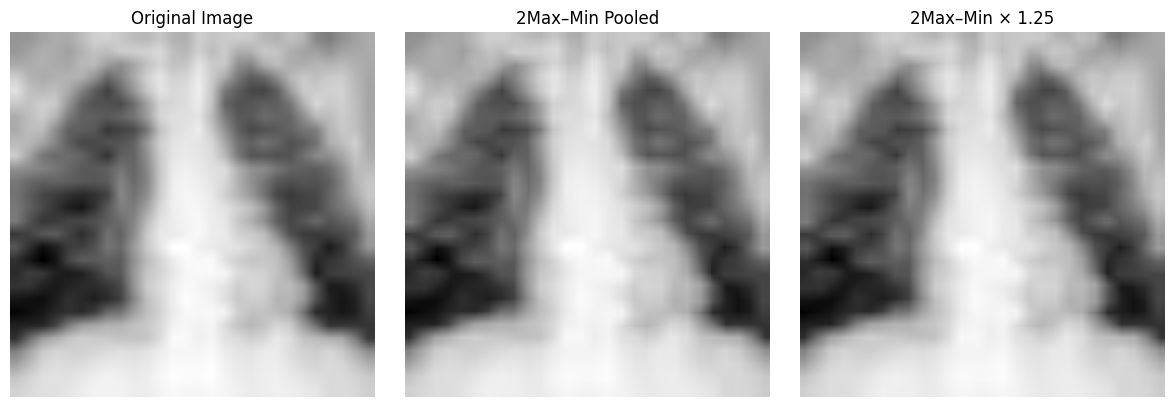

In [11]:
# Take one batch from Pneumonia train loader
images, labels = next(iter(train_loader))
img = images[0:1].to(device)   # (1, 3, H, W)

pool = TwoMaxMinusMinPool2d(kernel_size=2, stride=1).to(device)

MULTIPLIER = 1.25   # change to 1.25 if desired

with torch.no_grad():
    pooled = pool(img)
    scaled = pooled * MULTIPLIER

# Convert to numpy
orig_np   = img[0].cpu().numpy()
pooled_np = pooled[0].cpu().numpy()
scaled_np = scaled[0].cpu().numpy()

# Pick channel to visualize
ch = 0

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(orig_np[ch], cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(pooled_np[ch], cmap="gray")
axs[1].set_title("2Max–Min Pooled")
axs[1].axis("off")

axs[2].imshow(scaled_np[ch], cmap="gray")
axs[2].set_title(f"2Max–Min × {MULTIPLIER}")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [12]:
class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pretrained MobileNetV2
        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half of MobileNetV2 efficiently
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        # Split MobileNetV2 into blocks
        self.mobilenet_feature_blocks_1 = nn.Sequential(*pretrained_model.features[:num_blocks1 - 3])
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        # Output channel sizes
        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels # 160
        ch_last = self.mobilenet_block_last.out_channels # 1280
        ch_mid = self.mobilenet_block_mid.out_channels # 320
        ch_concat = ch_last + ch_2nd_last # 1440

        # CNN to ViT adapter
        adapter_layers = [
            nn.Conv2d(ch_mid, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        ]

        self.cnn_to_vit_adapter = nn.Sequential(*adapter_layers)

        # Initialize ViT encoder for 56×56 feature maps
        # Vit - 2 - stride variation
        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=48,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()  # return features, not logits


        # Enable overlapping patches by changing patch projection stride
        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels,
            old_proj.out_channels,
            kernel_size=8,
            stride=4,
            bias=old_proj.bias is not None,
        )


        # Infer number of patches produced by the new stride
        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)

        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape

        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches


        # Reset positional embeddings to match new token count
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)

        self.twomax_minus_min_pool = TwoMaxMinusMinPool2d(
            kernel_size=2,
            stride=1
        )

        # Vit - 1 - No stride variation
        self.vit_encoder2 = VisionTransformer(
            img_size=28, patch_size=7, in_chans=32,
            num_classes=0, embed_dim=48,
            depth=2, num_heads=4, mlp_ratio=2,
            qkv_bias=True, norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        # CNN parallel head (from features_last only)
        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 128, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=0), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # 6) Parallel on 4th-last features
        self.parallel2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=ch_mid,
                out_channels=ch_mid,
                kernel_size=3, stride=1, padding=0
            ),
            MaxAvgPool2d(pool_size=(3,3), stride=(1,1)),
            nn.Conv2d(ch_mid * 2, 64, 3, padding=0), nn.BatchNorm2d(64), nn.GELU(),
            nn.Conv2d(64, 8, 3, padding=0), nn.BatchNorm2d(8), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # Final classifier
        self.classifier_head = nn.Linear(48 + 48 + 128, num_classes)

    def forward(self, x):
        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        # Always resize to match before concat
        concatenated_cnn_features = torch.cat([features_last, features_2nd_last], dim=1)

        x = features_mid
        intermediate = None

        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)

            # capture second-last stage (before last 4 layers)
            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x

        vit_input1 = x                 # full adapter output
        vit_input2 = intermediate      # derived from vit_input1 path

        vit_features1 = self.vit_encoder1(vit_input1) # 64
        self.post_pool_gelu = nn.GELU()
        # Apply (2*max - min) pooling
        vit_input2 = self.twomax_minus_min_pool(vit_input2)
        vit_input2 = vit_input2 * 1.25
        vit_input2 = self.post_pool_gelu(vit_input2)
        # Resize to 28x28 explicitly
        vit_input2 = F.interpolate(
            vit_input2,
            size=(28, 28),
            mode="bilinear",
            align_corners=False
        )

        vit_features2 = self.vit_encoder2(vit_input2) # 32

        # CNN parallel branch from final MobileNet block
        cnn_features = self.cnn_parallel_head(concatenated_cnn_features) # 96
        # cnn_features_2 = self.parallel2(features_mid)   # [B, 64]

        # Concatenate and classify
        combined = torch.cat([vit_features1, vit_features2, cnn_features], dim=1)
        return self.classifier_head(combined)

In [13]:
model = CNN_ViT_Model(num_classes=2)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 2]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

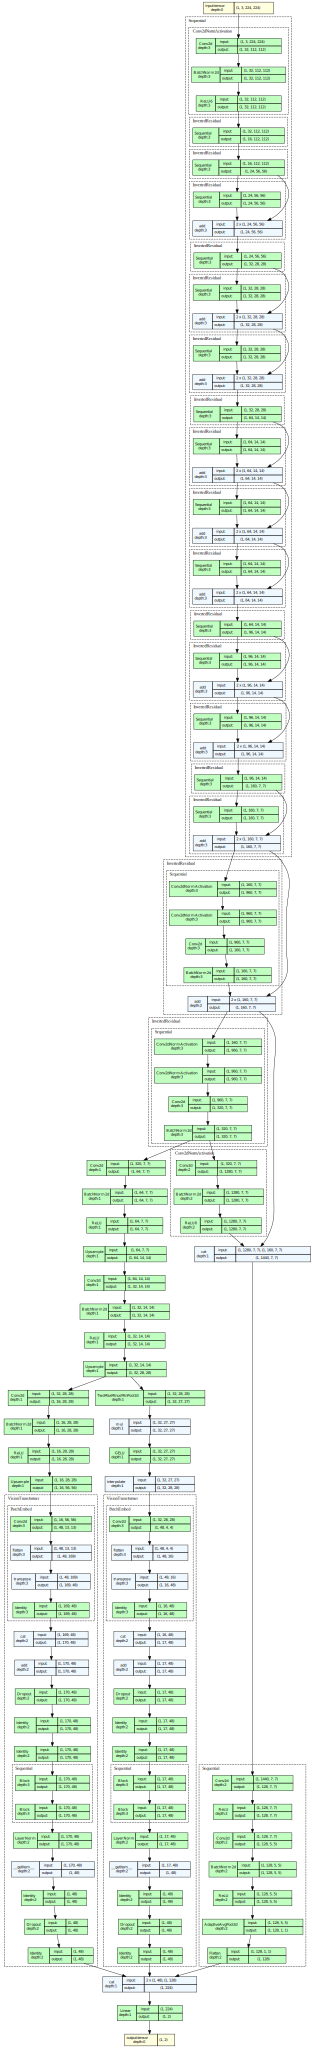

In [14]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [15]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [16]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 2e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [17]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/25]: 100%|██████████| 647/647 [00:21<00:00, 30.47it/s]


Train Metrics - loss: 0.1421, accuracy: 0.9397, precision: 0.9354, recall: 0.9397, f1_score: 0.9365, specificity: 0.5928, sensitivity: 0.9782, mcc: 0.6356, auc: 0.9589


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 66.67it/s]


Val Metrics - loss: 0.1608, accuracy: 0.9370, precision: 0.9401, recall: 0.9370, f1_score: 0.9344, specificity: 0.7704, sensitivity: 0.9949, mcc: 0.8331, auc: 0.9921
Epoch 0/25 — Loss: 0.1169 — LR: 0.000200


Training Epoch [2/25]: 100%|██████████| 647/647 [00:20<00:00, 31.70it/s]


Train Metrics - loss: 0.0861, accuracy: 0.9686, precision: 0.9679, recall: 0.9686, f1_score: 0.9681, specificity: 0.8119, sensitivity: 0.9860, mcc: 0.8209, auc: 0.9825


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 67.61it/s]


Val Metrics - loss: 0.1100, accuracy: 0.9695, precision: 0.9694, recall: 0.9695, f1_score: 0.9692, specificity: 0.9111, sensitivity: 0.9897, mcc: 0.9194, auc: 0.9929
Epoch 1/25 — Loss: 0.2932 — LR: 0.000200


Training Epoch [3/25]: 100%|██████████| 647/647 [00:19<00:00, 32.72it/s]


Train Metrics - loss: 0.0524, accuracy: 0.9817, precision: 0.9815, recall: 0.9817, f1_score: 0.9815, specificity: 0.8892, sensitivity: 0.9920, mcc: 0.8968, auc: 0.9940


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 49.66it/s]


Val Metrics - loss: 0.0925, accuracy: 0.9714, precision: 0.9727, recall: 0.9714, f1_score: 0.9717, specificity: 0.9778, sensitivity: 0.9692, mcc: 0.9277, auc: 0.9948
Epoch 2/25 — Loss: 0.0271 — LR: 0.000200


Training Epoch [4/25]: 100%|██████████| 647/647 [00:19<00:00, 32.51it/s]


Train Metrics - loss: 0.0348, accuracy: 0.9884, precision: 0.9884, recall: 0.9884, f1_score: 0.9884, specificity: 0.9381, sensitivity: 0.9940, mcc: 0.9354, auc: 0.9976


Validating Model: 100%|██████████| 88/88 [00:02<00:00, 40.01it/s]


Val Metrics - loss: 0.0875, accuracy: 0.9676, precision: 0.9676, recall: 0.9676, f1_score: 0.9676, specificity: 0.9407, sensitivity: 0.9769, mcc: 0.9154, auc: 0.9940
Epoch 3/25 — Loss: 0.0535 — LR: 0.000200


Training Epoch [5/25]: 100%|██████████| 647/647 [00:21<00:00, 30.47it/s]


Train Metrics - loss: 0.0254, accuracy: 0.9912, precision: 0.9912, recall: 0.9912, f1_score: 0.9912, specificity: 0.9562, sensitivity: 0.9951, mcc: 0.9513, auc: 0.9990


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 66.45it/s]


Val Metrics - loss: 0.1749, accuracy: 0.9504, precision: 0.9527, recall: 0.9504, f1_score: 0.9487, specificity: 0.8148, sensitivity: 0.9974, mcc: 0.8693, auc: 0.9929
Epoch 4/25 — Loss: 0.0279 — LR: 0.000200


Training Epoch [6/25]: 100%|██████████| 647/647 [00:21<00:00, 30.58it/s]


Train Metrics - loss: 0.0213, accuracy: 0.9915, precision: 0.9916, recall: 0.9915, f1_score: 0.9915, specificity: 0.9639, sensitivity: 0.9946, mcc: 0.9530, auc: 0.9992


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.73it/s]


Val Metrics - loss: 0.1690, accuracy: 0.9580, precision: 0.9591, recall: 0.9580, f1_score: 0.9570, specificity: 0.8519, sensitivity: 0.9949, mcc: 0.8892, auc: 0.9888
Epoch 5/25 — Loss: 0.0148 — LR: 0.000200


Training Epoch [7/25]: 100%|██████████| 647/647 [00:20<00:00, 30.98it/s]


Train Metrics - loss: 0.0274, accuracy: 0.9894, precision: 0.9894, recall: 0.9894, f1_score: 0.9894, specificity: 0.9433, sensitivity: 0.9946, mcc: 0.9411, auc: 0.9987


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.39it/s]


Val Metrics - loss: 0.1080, accuracy: 0.9676, precision: 0.9689, recall: 0.9676, f1_score: 0.9668, specificity: 0.8741, sensitivity: 1.0000, mcc: 0.9151, auc: 0.9961
Epoch 6/25 — Loss: 0.0052 — LR: 0.000200


Training Epoch [8/25]: 100%|██████████| 647/647 [00:21<00:00, 30.40it/s]


Train Metrics - loss: 0.0173, accuracy: 0.9956, precision: 0.9956, recall: 0.9956, f1_score: 0.9956, specificity: 0.9716, sensitivity: 0.9983, mcc: 0.9755, auc: 0.9989


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.95it/s]


Val Metrics - loss: 0.0632, accuracy: 0.9714, precision: 0.9713, recall: 0.9714, f1_score: 0.9713, specificity: 0.9407, sensitivity: 0.9820, mcc: 0.9250, auc: 0.9964
Epoch 7/25 — Loss: 0.0054 — LR: 0.000200


Training Epoch [9/25]: 100%|██████████| 647/647 [00:20<00:00, 31.67it/s]


Train Metrics - loss: 0.0071, accuracy: 0.9979, precision: 0.9979, recall: 0.9979, f1_score: 0.9979, specificity: 0.9897, sensitivity: 0.9989, mcc: 0.9885, auc: 0.9999


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 48.06it/s]


Val Metrics - loss: 0.1589, accuracy: 0.9485, precision: 0.9514, recall: 0.9485, f1_score: 0.9492, specificity: 0.9481, sensitivity: 0.9486, mcc: 0.8711, auc: 0.9911
Epoch 8/25 — Loss: 0.0057 — LR: 0.000200


Training Epoch [10/25]: 100%|██████████| 647/647 [00:20<00:00, 32.23it/s]


Train Metrics - loss: 0.0174, accuracy: 0.9943, precision: 0.9943, recall: 0.9943, f1_score: 0.9943, specificity: 0.9716, sensitivity: 0.9969, mcc: 0.9685, auc: 0.9986


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.47it/s]


Val Metrics - loss: 0.1049, accuracy: 0.9637, precision: 0.9662, recall: 0.9637, f1_score: 0.9643, specificity: 0.9778, sensitivity: 0.9589, mcc: 0.9099, auc: 0.9948
Epoch 9/25 — Loss: 0.0007 — LR: 0.000200


Training Epoch [11/25]: 100%|██████████| 647/647 [00:20<00:00, 31.07it/s]


Train Metrics - loss: 0.0092, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 0.9845, sensitivity: 0.9980, mcc: 0.9814, auc: 0.9998


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 62.90it/s]


Val Metrics - loss: 0.0921, accuracy: 0.9637, precision: 0.9635, recall: 0.9637, f1_score: 0.9635, specificity: 0.9111, sensitivity: 0.9820, mcc: 0.9043, auc: 0.9921
Epoch 10/25 — Loss: 0.0029 — LR: 0.000194


Training Epoch [12/25]: 100%|██████████| 647/647 [00:20<00:00, 31.15it/s]


Train Metrics - loss: 0.0140, accuracy: 0.9948, precision: 0.9948, recall: 0.9948, f1_score: 0.9948, specificity: 0.9742, sensitivity: 0.9971, mcc: 0.9714, auc: 0.9994


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.32it/s]


Val Metrics - loss: 0.1544, accuracy: 0.9599, precision: 0.9609, recall: 0.9599, f1_score: 0.9590, specificity: 0.8593, sensitivity: 0.9949, mcc: 0.8942, auc: 0.9859
Epoch 11/25 — Loss: 0.0132 — LR: 0.000188


Training Epoch [13/25]: 100%|██████████| 647/647 [00:20<00:00, 31.05it/s]


Train Metrics - loss: 0.0139, accuracy: 0.9948, precision: 0.9948, recall: 0.9948, f1_score: 0.9948, specificity: 0.9716, sensitivity: 0.9974, mcc: 0.9713, auc: 0.9997


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.01it/s]


Val Metrics - loss: 0.0637, accuracy: 0.9733, precision: 0.9733, recall: 0.9733, f1_score: 0.9730, specificity: 0.9185, sensitivity: 0.9923, mcc: 0.9295, auc: 0.9977
Epoch 12/25 — Loss: 0.0003 — LR: 0.000183


Training Epoch [14/25]: 100%|██████████| 647/647 [00:20<00:00, 30.88it/s]


Train Metrics - loss: 0.0071, accuracy: 0.9974, precision: 0.9974, recall: 0.9974, f1_score: 0.9974, specificity: 0.9871, sensitivity: 0.9986, mcc: 0.9857, auc: 0.9999


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 64.55it/s]


Val Metrics - loss: 0.0914, accuracy: 0.9771, precision: 0.9772, recall: 0.9771, f1_score: 0.9772, specificity: 0.9630, sensitivity: 0.9820, mcc: 0.9405, auc: 0.9952
Epoch 13/25 — Loss: 0.0010 — LR: 0.000177


Training Epoch [15/25]: 100%|██████████| 647/647 [00:20<00:00, 31.77it/s]


Train Metrics - loss: 0.0017, accuracy: 0.9997, precision: 0.9997, recall: 0.9997, f1_score: 0.9997, specificity: 1.0000, sensitivity: 0.9997, mcc: 0.9986, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:02<00:00, 43.68it/s]


Val Metrics - loss: 0.0929, accuracy: 0.9771, precision: 0.9770, recall: 0.9771, f1_score: 0.9770, specificity: 0.9407, sensitivity: 0.9897, mcc: 0.9397, auc: 0.9962
Epoch 14/25 — Loss: 0.0001 — LR: 0.000172


Training Epoch [16/25]: 100%|██████████| 647/647 [00:20<00:00, 31.40it/s]


Train Metrics - loss: 0.0150, accuracy: 0.9946, precision: 0.9946, recall: 0.9946, f1_score: 0.9946, specificity: 0.9716, sensitivity: 0.9971, mcc: 0.9699, auc: 0.9995


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 58.13it/s]


Val Metrics - loss: 0.1720, accuracy: 0.9618, precision: 0.9623, recall: 0.9618, f1_score: 0.9611, specificity: 0.8741, sensitivity: 0.9923, mcc: 0.8991, auc: 0.9918
Epoch 15/25 — Loss: 0.0058 — LR: 0.000167


Training Epoch [17/25]: 100%|██████████| 647/647 [00:20<00:00, 31.15it/s]


Train Metrics - loss: 0.0078, accuracy: 0.9982, precision: 0.9982, recall: 0.9982, f1_score: 0.9982, specificity: 0.9897, sensitivity: 0.9991, mcc: 0.9900, auc: 0.9997


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.35it/s]


Val Metrics - loss: 0.1141, accuracy: 0.9695, precision: 0.9699, recall: 0.9695, f1_score: 0.9690, specificity: 0.8963, sensitivity: 0.9949, mcc: 0.9195, auc: 0.9953
Epoch 16/25 — Loss: 0.0016 — LR: 0.000162


Training Epoch [18/25]: 100%|██████████| 647/647 [00:20<00:00, 30.93it/s]


Train Metrics - loss: 0.0070, accuracy: 0.9977, precision: 0.9977, recall: 0.9977, f1_score: 0.9977, specificity: 0.9871, sensitivity: 0.9989, mcc: 0.9871, auc: 0.9999


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.93it/s]


Val Metrics - loss: 0.2463, accuracy: 0.9370, precision: 0.9401, recall: 0.9370, f1_score: 0.9344, specificity: 0.7704, sensitivity: 0.9949, mcc: 0.8331, auc: 0.9948
Epoch 17/25 — Loss: 0.0019 — LR: 0.000157


Training Epoch [19/25]: 100%|██████████| 647/647 [00:20<00:00, 31.17it/s]


Train Metrics - loss: 0.0083, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 0.9845, sensitivity: 0.9980, mcc: 0.9814, auc: 0.9998


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 65.04it/s]


Val Metrics - loss: 0.1116, accuracy: 0.9695, precision: 0.9694, recall: 0.9695, f1_score: 0.9692, specificity: 0.9111, sensitivity: 0.9897, mcc: 0.9194, auc: 0.9956
Epoch 18/25 — Loss: 0.0008 — LR: 0.000152


Training Epoch [20/25]: 100%|██████████| 647/647 [00:20<00:00, 31.30it/s]


Train Metrics - loss: 0.0011, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 63.95it/s]


Val Metrics - loss: 0.1474, accuracy: 0.9695, precision: 0.9699, recall: 0.9695, f1_score: 0.9690, specificity: 0.8963, sensitivity: 0.9949, mcc: 0.9195, auc: 0.9959
Epoch 19/25 — Loss: 0.0002 — LR: 0.000147


Training Epoch [21/25]: 100%|██████████| 647/647 [00:20<00:00, 31.84it/s]


Train Metrics - loss: 0.0001, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 47.22it/s]


Val Metrics - loss: 0.1382, accuracy: 0.9695, precision: 0.9696, recall: 0.9695, f1_score: 0.9691, specificity: 0.9037, sensitivity: 0.9923, mcc: 0.9194, auc: 0.9961
Epoch 20/25 — Loss: 0.0001 — LR: 0.000143


Training Epoch [22/25]: 100%|██████████| 647/647 [00:20<00:00, 31.29it/s]


Train Metrics - loss: 0.0090, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 0.9871, sensitivity: 0.9977, mcc: 0.9815, auc: 0.9998


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 58.10it/s]


Val Metrics - loss: 0.0956, accuracy: 0.9676, precision: 0.9676, recall: 0.9676, f1_score: 0.9672, specificity: 0.9037, sensitivity: 0.9897, mcc: 0.9143, auc: 0.9964
Epoch 21/25 — Loss: 0.0014 — LR: 0.000139


Training Epoch [23/25]: 100%|██████████| 647/647 [00:20<00:00, 31.09it/s]


Train Metrics - loss: 0.0037, accuracy: 0.9987, precision: 0.9987, recall: 0.9987, f1_score: 0.9987, specificity: 0.9923, sensitivity: 0.9994, mcc: 0.9928, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 64.13it/s]


Val Metrics - loss: 0.2009, accuracy: 0.9637, precision: 0.9641, recall: 0.9637, f1_score: 0.9631, specificity: 0.8815, sensitivity: 0.9923, mcc: 0.9042, auc: 0.9928
Epoch 22/25 — Loss: 0.0012 — LR: 0.000135


Training Epoch [24/25]: 100%|██████████| 647/647 [00:21<00:00, 30.40it/s]


Train Metrics - loss: 0.0046, accuracy: 0.9985, precision: 0.9985, recall: 0.9985, f1_score: 0.9985, specificity: 0.9948, sensitivity: 0.9989, mcc: 0.9914, auc: 1.0000


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 64.84it/s]


Val Metrics - loss: 0.2069, accuracy: 0.9637, precision: 0.9649, recall: 0.9637, f1_score: 0.9629, specificity: 0.8667, sensitivity: 0.9974, mcc: 0.9047, auc: 0.9940
Epoch 23/25 — Loss: 0.0018 — LR: 0.000131


Training Epoch [25/25]: 100%|██████████| 647/647 [00:21<00:00, 30.16it/s]


Train Metrics - loss: 0.0050, accuracy: 0.9977, precision: 0.9977, recall: 0.9977, f1_score: 0.9977, specificity: 0.9871, sensitivity: 0.9989, mcc: 0.9871, auc: 0.9999


Validating Model: 100%|██████████| 88/88 [00:01<00:00, 63.49it/s]

Val Metrics - loss: 0.1396, accuracy: 0.9695, precision: 0.9693, recall: 0.9695, f1_score: 0.9692, specificity: 0.9185, sensitivity: 0.9871, mcc: 0.9194, auc: 0.9936
Epoch 24/25 — Loss: 0.0020 — LR: 0.000127
Total Training Time: 0:08:38.513606
Total Validation Time: 0:00:37.104596
Average Training Time per Epoch: 0:00:20.740544
Average Validation Time per Epoch: 0:00:01.484184


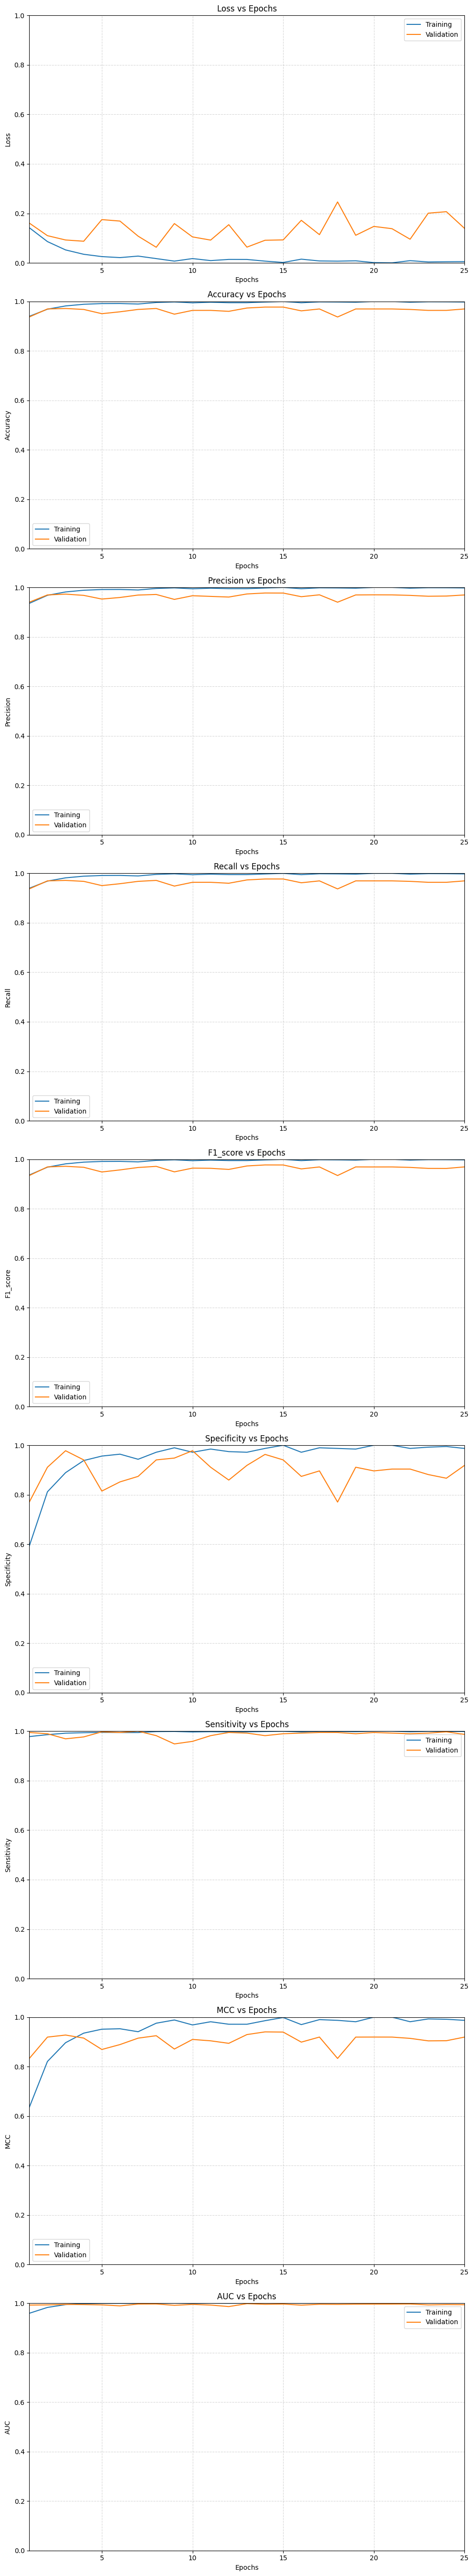

In [18]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [19]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 104/104 [00:01<00:00, 64.02it/s]

Test Metrics - loss: 1.2038, accuracy: 0.8349, precision: 0.8694, recall: 0.8349, f1_score: 0.8213, specificity: 0.5598, sensitivity: 1.0000, mcc: 0.6655, auc: 0.9395


In [20]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_test_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# # Option 2: if using ImageFolder
# classes = dataset.classes

# Class names in correct index order
class_name_map = {
    0: "Normal",
    1: "Pneumonia Present",
}
classes = [class_name_map[i] for i in sorted(class_name_map.keys())]

# Get class names from the dataset
# classes = train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                   precision    recall  f1-score   support

           Normal     1.0000    0.5598    0.7178       234
Pneumonia Present     0.7911    1.0000    0.8834       390

         accuracy                         0.8349       624
        macro avg     0.8955    0.7799    0.8006       624
     weighted avg     0.8694    0.8349    0.8213       624

There were 103 errors in 624 tests for an accuracy of  83.49
